In [5]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import roc_auc_score

from imblearn.over_sampling import SMOTE

import pickle

import keras 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.models import load_model

In [2]:
NN = load_model('../lipika/NN_final_model.h5')
LGBM_train = pd.read_csv("../lipika/lgbm_preds_training")
LGBM_test = pd.read_csv("../lipika/lgbm_preds_test")

In [3]:
LGBM_train['annualized_amnt'] = LGBM_train['amnt']
LGBM_test['annualized_amnt'] = LGBM_test['amnt']

In [4]:
LGBM_train.head()

,Unnamed: 0,pred,proba,true_val,int_rate,amnt,total_pymnt,term_adj,ROI,Real_ROI,annualized_amnt
0,0,0,0.220892,1,0.0699,10400.0,6611.69,3.000000,-0.067034,-1457.484111,10400.0
1,1,0,0.466711,0,0.1239,15000.0,17392.37,1.500000,-0.190622,1555.269831,15000.0
2,2,0,0.342499,1,0.1366,7650.0,2281.98,3.000000,-0.098564,-2538.540767,7650.0
3,3,0,0.423445,0,0.1366,9600.0,9973.43,0.333333,-0.154142,1164.433162,9600.0
4,4,1,0.708332,0,0.1559,21425.0,25512.20,1.416667,-0.344120,2810.156493,21425.0


In [6]:
data_train = pd.read_csv("../lipika/cleaned_2013_14", low_memory = False);
data_test = pd.read_csv("../lipika/cleaned_2015", low_memory = False);
data_test = data_test.dropna()
data_train = data_train.dropna()

In [7]:
data_train.shape

(351757, 50)

In [8]:
data_test = data_test[data_test.int_rate < 0.5]
data_train = data_test[data_train.int_rate < 0.5]

/Users/hugoramambason/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [9]:
data_train['int_rate_real'] = data_train.int_rate
data_test['int_rate_real'] = data_test.int_rate

/Users/hugoramambason/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [10]:
data_train.int_rate = data_train.int_rate/np.amax(data_train.int_rate)
data_train['model_term'] = data_train.term/np.amax(data_train.term)
data_train.dti = data_train.dti/np.amax(data_train.dti)
data_train.revol_util = data_train.revol_util/np.amax(data_train.revol_util)

data_test.int_rate = data_test.int_rate/np.amax(data_test.int_rate)
data_test['model_term'] = data_test.term/np.amax(data_train.term)
data_test.dti = data_test.dti/np.amax(data_test.dti)
data_test.revol_util = data_test.revol_util/np.amax(data_test.revol_util)

/Users/hugoramambason/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/Users/hugoramambason/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
def split_data(df, cols):
    x = df.drop(cols, axis = 1)
    y = df.paid
    return x, y

cols_to_drop_training = ['loan_status', 'paid', 'amnt', 'total_pymnt', 
                         'term_adj', 'term', 'zip_code', 'int_rate_real']
x_train, y_train = split_data(data_train, cols_to_drop_training)
x_test, y_test = split_data(data_test, cols_to_drop_training)

In [12]:
def create_df(data_1, data_2, penal = 0):
    df = pd.DataFrame(data_1)
    df['proba'] = df.proba.map(lambda x: x[0])
    df['pred'] = df.pred.map(lambda x:x[0])
    
    df['int_rate'] = data_2['int_rate_real']
    df['amnt'] = data_2['amnt']
    df['total_pymnt'] = data_2['total_pymnt']
    df['term_adj'] = data_2['term_adj']
    df['ROI'] = (((1 + df['int_rate'])*(1-df['proba']))+(df['proba']*drr*penal))-1

    df['Real_ROI'] = df['amnt']*(((df['total_pymnt']/df['amnt'])**(1/df['term_adj']))-1)
    df['annualized_amnt'] = df['amnt'] #*(1/df['term_adj'])
    
    return df

In [13]:
data_train.shape

(346479, 52)

In [78]:
distress = data_train[data_train.paid == 1]
drr = (np.sum(distress.total_pymnt)/np.sum(distress.amnt))**(1/np.mean(distress.term))
print(drr)

0.8674571280898923


In [79]:
NN_train_predictions = (NN.predict(x_train))
NN_test_predictions = (NN.predict(x_test))
NN_train_class = np.where(NN_train_predictions > 0.50, 1, 0)
NN_test_class = np.where(NN_test_predictions > 0.50, 1, 0)

In [80]:
train_data = {'proba' : NN_train_predictions.tolist(), 'pred' : NN_train_class.tolist(), 'true_val' : y_train}
test_data = {'proba' : NN_test_predictions.tolist(), 'pred' : NN_test_class.tolist(), 'true_val' : y_test}
NN_train = create_df(train_data, data_train)
NN_test =  create_df(test_data, data_test)

In [81]:
NN_test.head()

,proba,pred,true_val,int_rate,amnt,total_pymnt,term_adj,ROI,Real_ROI,annualized_amnt
0,0.943091,1,0,0.1288,10000.0,11316.890190,1.250000,-0.935761,1040.320509,10000.0
1,0.953753,1,0,0.0749,18000.0,19771.097253,1.833333,-0.950289,945.422167,18000.0
2,0.161011,0,0,0.0532,20000.0,21631.724329,2.666667,-0.116377,596.950472,20000.0
3,0.626151,1,1,0.1399,17475.0,13449.650000,3.000000,-0.573849,-1460.436080,17475.0
4,0.784400,1,0,0.1344,21000.0,24473.227622,1.416667,-0.755423,2395.949463,21000.0


/Users/hugoramambason/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


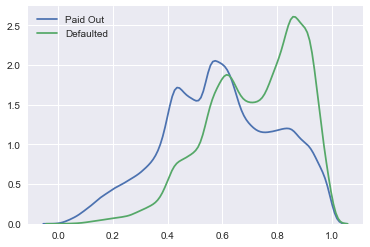

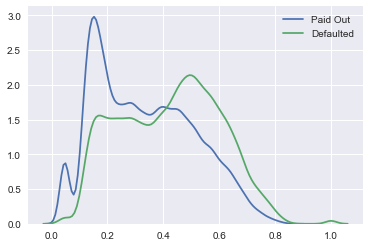

In [82]:
sns.kdeplot(NN_test.loc[NN_test.true_val == 0,'proba'], label = 'Paid Out');
sns.kdeplot(NN_test.loc[NN_test.true_val == 1,'proba'], label = 'Defaulted');
plt.show()

sns.kdeplot(LGBM_test.loc[LGBM_test.true_val == 0,'proba'], label = 'Paid Out');
sns.kdeplot(LGBM_test.loc[LGBM_test.true_val == 1,'proba'], label = 'Defaulted');
plt.show()

/Users/hugoramambason/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


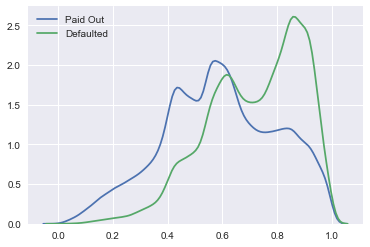

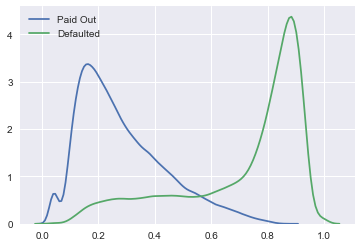

In [83]:
sns.kdeplot(NN_train.loc[NN_train.true_val == 0,'proba'], label = 'Paid Out');
sns.kdeplot(NN_train.loc[NN_train.true_val == 1,'proba'], label = 'Defaulted');
plt.show()

sns.kdeplot(LGBM_train.loc[LGBM_train.true_val == 0,'proba'], label = 'Paid Out');
sns.kdeplot(LGBM_train.loc[LGBM_train.true_val == 1,'proba'], label = 'Defaulted');
plt.show()

In [84]:
NN_train = NN_train.sort_values(by=['ROI'], ascending=False)
NN_test = NN_test.sort_values(by=['ROI'], ascending=False)
LGBM_train = LGBM_train.sort_values(by=['ROI'], ascending=False)
LGBM_test = LGBM_test.sort_values(by=['ROI'], ascending=False)

In [85]:
def create_strategy_curve(df):
    df['cumsum_prop_loans'] = df.amnt.cumsum()/np.sum(df.amnt)
    df['cumsum_ROI'] = df.Real_ROI.cumsum()/df.annualized_amnt.cumsum()
    return df

In [86]:
NN_train = create_strategy_curve(NN_train)
NN_test = create_strategy_curve(NN_test)
LGBM_train = create_strategy_curve(LGBM_train)
LGBM_test = create_strategy_curve(LGBM_test)

In [87]:
np.sum(NN_test.Real_ROI)

165357645.56314617

In [88]:
np.sum(LGBM_test.Real_ROI)

165357645.5631462

In [89]:
NN_test.describe()

,proba,pred,true_val,int_rate,amnt,total_pymnt,term_adj,ROI,Real_ROI,annualized_amnt,cumsum_prop_loans,cumsum_ROI
count,346681.000000,346681.000000,346681.000000,346681.000000,346681.000000,346681.000000,346681.000000,346681.000000,346681.000000,346681.000000,3.466810e+05,346681.000000
mean,0.618099,0.706390,0.222374,0.124815,14670.333679,14936.388513,2.393903,-0.576387,476.973487,14670.333679,4.757133e-01,0.036894
std,0.208215,0.455416,0.415842,0.043458,8514.696346,9943.091253,1.237498,0.221888,2165.173417,8514.696346,2.874596e-01,0.001793
min,0.000593,0.000000,0.000000,0.053200,1000.000000,0.000000,0.040000,-0.999352,-35000.000000,1000.000000,7.078357e-07,0.032513
25%,0.469475,0.000000,0.000000,0.091700,8000.000000,7220.320000,1.500000,-0.761665,211.704879,8000.000000,2.269253e-01,0.036158
50%,0.616335,1.000000,0.000000,0.122900,12600.000000,12421.690000,2.583333,-0.567455,645.672108,12600.000000,4.619247e-01,0.037250
75%,0.791720,1.000000,0.000000,0.154100,20000.000000,20640.320000,3.000000,-0.415641,1362.403040,20000.000000,7.149465e-01,0.038093
max,0.999478,1.000000,1.000000,0.289900,35000.000000,59265.976314,5.000000,0.132787,21506.599818,35000.000000,1.000000e+00,0.195804


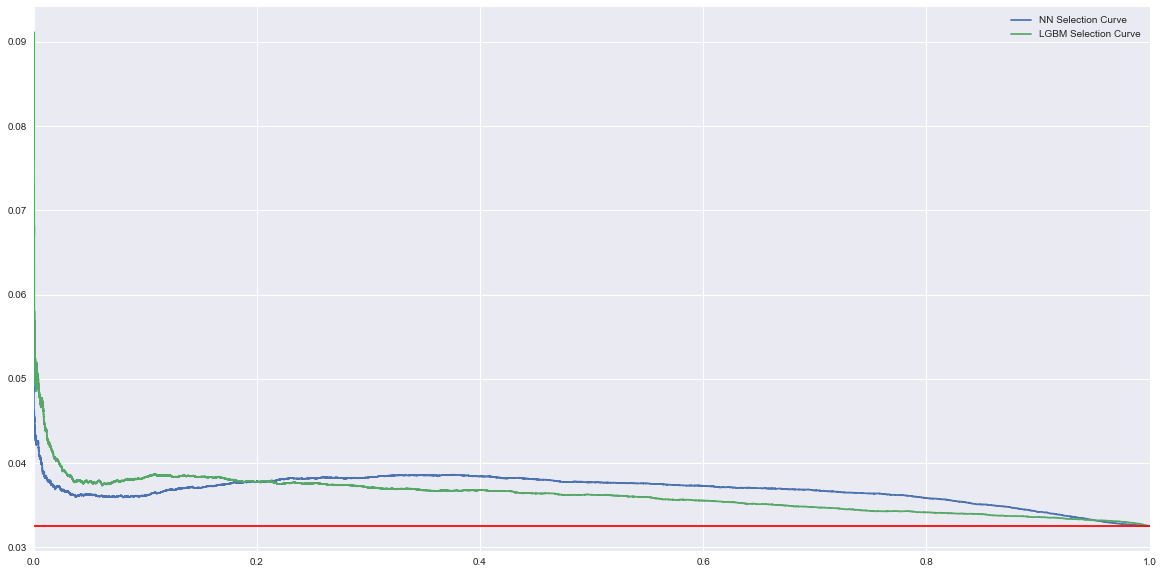

In [90]:
i = 100
plt.figure(figsize=(20,10))
plt.plot(NN_test.cumsum_prop_loans[i:], NN_test.cumsum_ROI[i:], label = 'NN Selection Curve')
plt.plot(LGBM_test.cumsum_prop_loans[i:], LGBM_test.cumsum_ROI[i:], label = 'LGBM Selection Curve')
plt.axhline(np.sum(NN_test.Real_ROI)/np.sum(NN_test.annualized_amnt), color = 'r')
plt.legend()
plt.xlim(0,1)
plt.show()

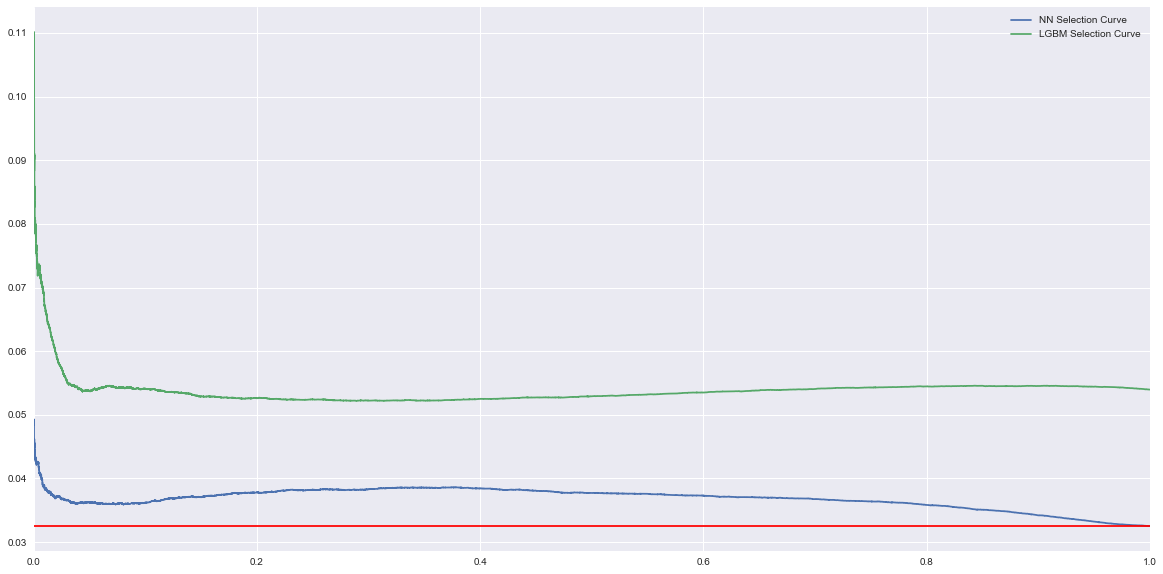

In [92]:
i = 100
plt.figure(figsize=(20,10))
plt.plot(NN_train.cumsum_prop_loans[i:], NN_train.cumsum_ROI[i:], label = 'NN Selection Curve')
plt.plot(LGBM_train.cumsum_prop_loans[i:], LGBM_train.cumsum_ROI[i:], label = 'LGBM Selection Curve')
plt.axhline(np.sum(NN_train.Real_ROI)/np.sum(NN_train.annualized_amnt), color = 'r')
plt.legend()
plt.xlim(0, 1)
plt.show()

In [93]:
NN_train

,proba,pred,true_val,int_rate,amnt,total_pymnt,term_adj,ROI,Real_ROI,annualized_amnt,cumsum_prop_loans,cumsum_ROI
329549,0.003355,0,0,0.1366,3600.0,4424.868271,3.166667,0.132787,242.346771,3600.0,7.082312e-07,0.067319
119796,0.005153,0,0,0.1333,5000.0,5982.471916,2.083333,0.127460,449.631331,5000.0,1.691886e-06,0.080463
223284,0.105164,0,0,0.2599,23100.0,30731.810030,1.333333,0.127403,5515.023039,23100.0,6.236370e-06,0.195804
246668,0.000593,0,0,0.0999,3600.0,3622.980000,0.083333,0.099247,285.650463,3600.0,6.944601e-06,0.183928
327007,0.033955,0,0,0.1199,10000.0,11057.310000,1.500000,0.081874,693.002221,10000.0,8.911910e-06,0.158624
61526,0.032793,0,0,0.1153,5000.0,5120.760000,0.166667,0.078726,769.743532,5000.0,9.895564e-06,0.158159
38396,0.065987,0,0,0.1541,1000.0,1230.160390,2.333333,0.077944,92.836096,1000.0,1.009230e-05,0.156886
2289,0.010678,0,0,0.0849,5000.0,5080.810000,0.250000,0.073315,331.161082,5000.0,1.107595e-05,0.148835
228131,0.003740,0,0,0.0692,16000.0,16084.700000,0.083333,0.065201,1046.521589,16000.0,1.422364e-05,0.130372
57509,0.026838,0,0,0.0917,1000.0,1091.367589,1.166667,0.062401,77.820938,1000.0,1.442038e-05,0.129655


In [ ]:
NN_train.tail(500)

In [ ]:
data_train.iloc[311111, :]